#Installing Dependencies

In [1]:
# !pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

2023-11-25 22:01:08.195503: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 22:01:08.514010: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 22:01:09.239562: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/harsha/anaconda3/envs/tf/lib/
2023-11-25 22:01:09.239682: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin

In [2]:
df = pd.read_csv(os.path.join('train.csv'))

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# %pip list

Feature Selection and Vectorization

In [4]:
from tensorflow.keras.layers import TextVectorization

In [5]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [6]:
MAX_FEATURES = 200000 # number of words in the vocab

In [7]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

2023-11-25 22:01:20.769220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-25 22:01:20.854556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-25 22:01:20.855020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-25 22:01:20.855982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
vectorizer.adapt(X.values)

In [9]:
vectorized_text = vectorizer(X.values)

2023-11-25 22:01:31.397115: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2297822400 exceeds 10% of free system memory.


In [10]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

Training data and Validation Data

In [11]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

Saving Training Metrics Based of Epochs

In [12]:
import time
from tensorflow.keras.callbacks import Callback

class MetricsLogger(Callback):
    def __init__(self, log_file):
        self.log_file = log_file
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        current_time = time.time()
        elapsed_time = current_time - self.start_time
        self.start_time = current_time

        # Log information to a text file
        with open(self.log_file, 'a') as f:
            f.write(f"Epoch {epoch + 1} - Time: {elapsed_time:.2f}s - "
                    f"Loss: {logs['loss']:.4f} - "
                    f"Validation Loss: {logs['val_loss']:.4f}\n")

RNN Model --> using text vectorization

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

Sample Model - 1 (EXP)

In [28]:
log_file = 'model1_training_log.txt'

model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [29]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [31]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 256)               16640     
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dense_15 (Dense)            (None, 6)                 774       
                                                      

In [32]:
logger = MetricsLogger(log_file)
history = model.fit(train, epochs=10, validation_data=val, callbacks=[logger])

Epoch 1/10


6981/6981 [==============================] - ETA: 0s - loss: 0.0623

2023-11-25 22:16:03.565023: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2297822400 exceeds 10% of free system memory.


6981/6981 [==============================] - 516s 74ms/step - loss: 0.0623 - val_loss: 0.0454
Epoch 2/10
6981/6981 [==============================] - 549s 79ms/step - loss: 0.0458 - val_loss: 0.0398
Epoch 3/10
6981/6981 [==============================] - 564s 81ms/step - loss: 0.0410 - val_loss: 0.0372
Epoch 4/10
6981/6981 [==============================] - 564s 81ms/step - loss: 0.0365 - val_loss: 0.0314
Epoch 5/10
6981/6981 [==============================] - 488s 70ms/step - loss: 0.0329 - val_loss: 0.0291
Epoch 6/10
6981/6981 [==============================] - 488s 70ms/step - loss: 0.0296 - val_loss: 0.0270
Epoch 7/10
6981/6981 [==============================] - 478s 69ms/step - loss: 0.0270 - val_loss: 0.0231
Epoch 8/10
6981/6981 [==============================] - 471s 67ms/step - loss: 0.0239 - val_loss: 0.0198
Epoch 9/10
6981/6981 [==============================] - 487s 70ms/step - loss: 0.0214 - val_loss: 0.0183
Epoch 10/10
6981/6981 [==============================] - 582s 83ms

In [33]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

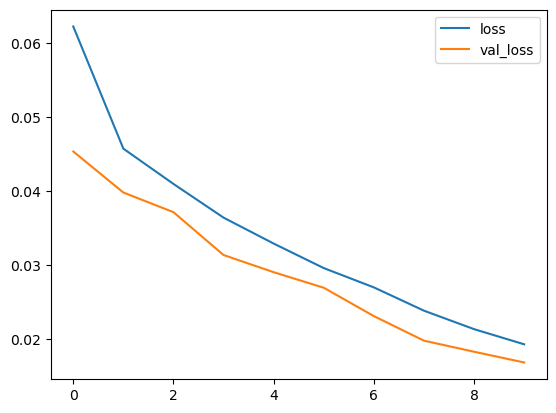

In [34]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [35]:
model.save('toxicity_10epochs_model1.h5')

Sample Model - 2 (EXP)

In [36]:
log_file = 'model2_training_log.txt'

model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(64, activation='tanh')))  # Adjusted units and activation
model.add(Dense(256, activation='elu'))  # Adjusted units and activation
model.add(Dense(128, activation='tanh'))  # Adjusted activation
model.add(Dense(64, activation='relu'))   # Adjusted units and activation
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

In [37]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 256)               33024     
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                      

In [39]:
logger = MetricsLogger(log_file)
history = model.fit(train, epochs=10, validation_data=val, callbacks=[logger])

Epoch 1/10


6981/6981 [==============================] - 723s 103ms/step - loss: 0.0661 - val_loss: 0.0476
Epoch 2/10
6981/6981 [==============================] - 617s 88ms/step - loss: 0.0476 - val_loss: 0.0440
Epoch 3/10
6981/6981 [==============================] - 568s 81ms/step - loss: 0.0425 - val_loss: 0.0402
Epoch 4/10
6981/6981 [==============================] - 692s 99ms/step - loss: 0.0393 - val_loss: 0.0359
Epoch 5/10
6981/6981 [==============================] - 832s 119ms/step - loss: 0.0365 - val_loss: 0.0328
Epoch 6/10
6981/6981 [==============================] - 847s 121ms/step - loss: 0.0342 - val_loss: 0.0322
Epoch 7/10
6981/6981 [==============================] - 844s 121ms/step - loss: 0.0318 - val_loss: 0.0289
Epoch 8/10
6981/6981 [==============================] - 855s 122ms/step - loss: 0.0298 - val_loss: 0.0264
Epoch 9/10
6981/6981 [==============================] - 726s 104ms/step - loss: 0.0280 - val_loss: 0.0260
Epoch 10/10
6981/6981 [==============================] - 745

In [40]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

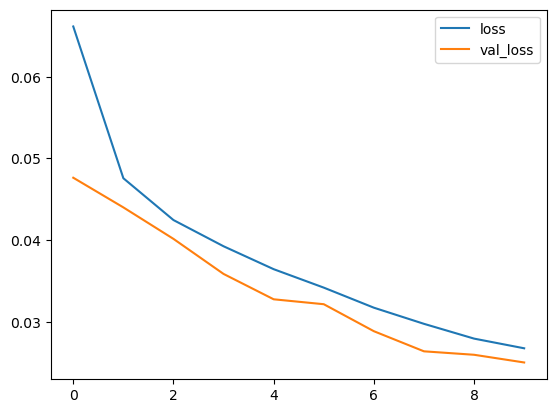

In [41]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [42]:
model.save('toxicity_10epochs_model2.h5')

Evaluate Model

In [ ]:
model = tf.keras.models.load_model('toxicity_5epochs_model1.h5')

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

2023-11-17 16:25:24.623196: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2297822400 exceeds 10% of free system memory.


1/1 [==============================] - 0s 60ms/step


In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9799593091011047, Recall:0.9805288910865784, Accuracy:0.5075225830078125


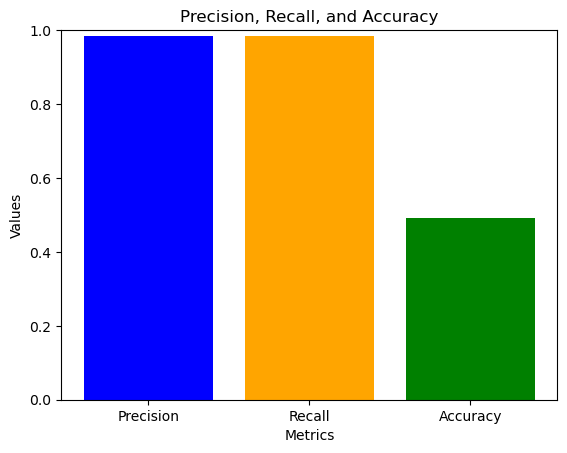

In [ ]:

precision_value = pre.result().numpy()
recall_value = re.result().numpy()
accuracy_value = acc.result().numpy()

# Create a bar plot
labels = ['Precision', 'Recall', 'Accuracy']
values = [precision_value, recall_value, accuracy_value]

plt.bar(labels, values, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)  # Set the y-axis limit to be between 0 and 1 for better visualization

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Precision, Recall, and Accuracy')

# Show the plot
plt.show()

Gradio Interface

In [ ]:
# !pip install gradio jinja2

In [ ]:
import tensorflow as tf
import gradio as gr

In [ ]:
model = tf.keras.models.load_model('toxicity_3epochs_model2.h5')

In [ ]:
input_str = vectorizer('hey i freaken hate you!')

In [ ]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 0s 456ms/step


In [ ]:
res

array([[0.87642527, 0.01246697, 0.31956816, 0.01832792, 0.39738086,
        0.05755312]], dtype=float32)

In [ ]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [ ]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [ ]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


1/1 [==============================] - 0s 50ms/step


Prediction Testing

In [ ]:
input_text_1 = vectorizer('You freaking suck! I am going to hit you.')

In [ ]:
input_text_1

In [ ]:
res = model.predict(np.array([input_text_1]))

In [ ]:
rex = model.predict(np.expand_dims(input_text_1,0))

In [ ]:
(res > 0.5).astype(int)

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

In [ ]:
res.shape